# Collecting data from GooglePlay

This notebook is used to collect the dataset 'reviews.csv'. You are free to modify this code and customise the dataset according to your goals.

**Note:**

This code is designed to collect almost similar number of positive and negative reviews. However, it aims to show a way of data collection, may not be case of your analysis.

The function used for scraping app info and reviews is [google-play-scraper](https://github.com/JoMingyu/google-play-scraper).

## Setup

Let's install the required packages and setup the imports:

In [2]:
# First time running this code, you need to install package 'google_play_scraper' 
# !pip install --upgrade google_play_scraper

     |████████████████████████████████| 49 kB 2.1 MB/s eta 0:00:01
  Created wheel for google-play-scraper: filename=google_play_scraper-0.1.2-py3-none-any.whl size=36969 sha256=b290af5c48ab22939c28705979eebdbfdf729ef085adb06699e4d2a90be959fa
  Stored in directory: /Users/yishanho/Library/Caches/pip/wheels/8c/16/47/0ac3fa962581ee630c41543b7ea25b407ae008edcdc14a5626
Successfully built google-play-scraper


In [1]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app


Now let's create a list of Apps we want to collect.

We will need 'the Google Play ID', which is the unique identifier of an Android application. 
It can be found by searching for the app and finding the Play store web page for the app.

In the example below, the Google Play ID is ``com.amazon.mShop.android.shopping``, which you can find directly from its url address:

https://play.google.com/store/apps/details?id=com.amazon.mShop.android.shopping

You are free to define your own list of Apps.

In [2]:
# List of Apps and their packages to be collected. Here I choose some Apps under the category 'productivity'

# app_packages = [
#     'com.amazon.mShop.android.shopping',
#     'com.tesco.grocery.view',
#     'com.homeretailgroup.argos.android',
#     'com.morrisons.atm.mobile.android',
#     'com.marksandspencer.app',
#     'com.boots.flagship.android',
# ]
app_packages = ['co.uk.getmondo',
               'com.revolut.revolut',
               'com.grppl.android.shell.BOS',
               'com.barclays.android.barclaysmobilebanking',
               'uk.co.hsbc.hsbcukmobilebanking',
               'com.grppl.android.shell.CMBlloydsTSB73',
               'uk.co.santander.santanderUK',
               'uk.co.tsb.newmobilebank',
               'com.rbs.mobile.android.rbs',
               'ph.com.metrobank.metrobankdirectmobile',
               'com.grppl.android.shell.halifax']

#                'com.rbs.banklinemobile.natwest',

## Scraping App Information

Let's scrape the info for each app:

In [3]:
app_infos = []

for ap in tqdm(app_packages):
    info = app(ap, lang='en', country='uk') # from the UK markert
    del info['comments']
    app_infos.append(info)

100%|██████████| 11/11 [00:03<00:00,  3.07it/s]


Let's look at the corresponding JSON objects:

In [4]:
def print_json(json_object):
    json_str = json.dumps(
        json_object, 
        indent=2, 
        sort_keys=True, 
        default=str
    )
    print(highlight(json_str, JsonLexer(), TerminalFormatter()))

Here is a sample app information from the list:

In [5]:
print_json(app_infos[0])

{
  "adSupported": null,
  "androidVersion": "5.0",
  "androidVersionText": "5.0 and up",
  "appId": "co.uk.getmondo",
  "containsAds": false,
  "contentRating": "PEGI 3",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "Instant spending updates. Smart budgeting. Great rates abroad. Emoji \ud83d\ude4c\r\n\r\nWe\u2019re a bank, but we\u2019re trying not to think like one. Open an account with us in minutes, and start getting to know your money better.\r\n\r\nWe\u2019ve been busy for the last few years building the best current account in the world. Now more than 1,000,000 people use Monzo to manage their money and spend around the world. Download the app today to join them.\r\n\r\n<b>Manage your money</b>\r\n\r\n- <b>Set spending budgets</b>\r\n  Set monthly budgets for spending on things like groceries and going out.\r\n- <b>See an easy summary</b>\r\n  See an overview of your account any time, with notifications if you\u2019re spending too fast.\r\n- <b>Get i

## Print Logos

This contains lots of information including the number of ratings, number of reviews and number of ratings for each score (1 to 5). We can select what is relevant and even some of the info we like. For example, we can print all their logos. 

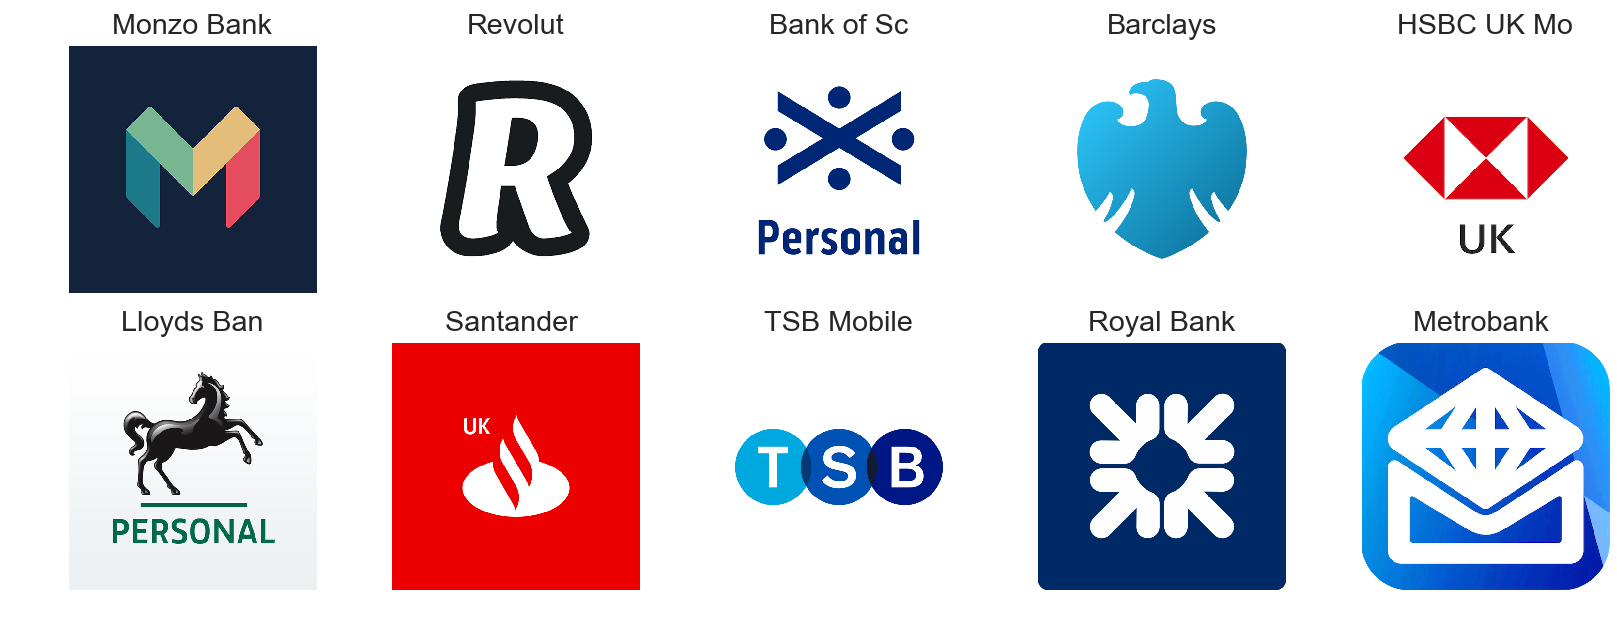

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Function to format and get the title
def format_title(title):
    sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
    
    if sep_index != -1:
        title = title[:sep_index]
    return title[:10]

# Print logos and titles
fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(14, 5))

for i, ax in enumerate(axs.flat):
    ai = app_infos[i]
    img = plt.imread(ai['icon'])
    ax.imshow(img)
    ax.set_title(format_title(ai['title']))
    ax.axis('off')

We'll store the app information for later by converting the JSON objects into a Pandas dataframe and saving the result into a CSV file:

In [7]:
# App Data into Pandas DF and store it
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('./apps.csv', index=None, header=True)

## Scraping App Reviews

In an ideal world, we would get all the reviews. But there are lots of them and we're scraping the data. That wouldn't be very polite. What should we do?

We want:

- Balanced dataset - roughly the same number of reviews for each score (1-5)
- A representative sample of the reviews for each app

We can satisfy the first requirement by using the scraping package option to filter the review score. For the second, we'll sort the reviews by their helpfulness, which are the reviews that Google Play thinks are most important. Just in case, we'll get a subset from the newest, too:

See https://github.com/JoMingyu/google-play-scraper for configurations of function ``google_play_scraper.reviews``.

In [8]:
# This is an example of the function google_play_scraper.reviews
result, continuation_token = reviews(
    'com.fantome.penguinisle',
    lang='en', # defaults to 'en'
    country='us', # defaults to 'us'
    sort=Sort.MOST_RELEVANT, # defaults to Sort.MOST_RELEVANT
    count=1, # defaults to 100
    filter_score_with=5 # defaults to None(means all score)
)
result

[{'at': datetime.datetime(2021, 3, 25, 6, 52, 53),
  'content': "The graphics are just the cutest, this game always makes me smile. I do wish there were less reliance on ads, this definitely makes the game less relaxing. I'd love it a lot more if you could get coins by solving some sort of puzzle instead!! EDIT: With the updates there is less reliance on ads and a mini-game! If I could give this app more than 5 stars I definitely would!",
  'repliedAt': None,
  'replyContent': None,
  'reviewCreatedVersion': '1.32.0',
  'reviewId': 'gp:AOqpTOFLm6GokMZpv5eSk5gDeLL766NSCt4OejdAGoihK34-VISeO8LKnEOQZ79WbL8fcdsOXJD-RtdwT-VyD-A',
  'score': 5,
  'thumbsUpCount': 16,
  'userImage': 'https://play-lh.googleusercontent.com/a-/AOh14Gj6hVfgfA-pC5MQPKI9bJ73vPJjCy0v7Ui_aScu',
  'userName': 'Livia Way'}]

In [9]:
app_reviews = []

# Loop through all the app packages and collect review for each of them
for ap in tqdm(app_packages):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='en',
                country='uk',
                sort=sort_order,
                count= 150 if score == 3 else 200,
                filter_score_with=score
            )
        for r in rvs:
            r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
            r['appId'] = ap

        app_reviews.extend(rvs)

100%|██████████| 11/11 [01:04<00:00,  5.85s/it]


Note that we're adding the app id and sort order to each review. Here's an example for one:

In [10]:
print_json(app_reviews[0])

{
  "appId": "co.uk.getmondo",
  "at": "2021-03-27 14:30:30",
  "content": "Not helpful at all",
  "repliedAt": "2021-03-27 14:38:08",
  "replyContent": "Hey Tracey, we're so sorry that you've not found us helpful! If you have any questions, or need help with your account please send us an email to help@monzo.com and we'd be happy to try our best to help you out  \ud83d\udee0",
  "reviewCreatedVersion": "3.74.0",
  "reviewId": "gp:AOqpTOEYeN1ad3w6d35J7yIwbnDz_ygA538qW6iQf-FCOBpu-yNlt8ImzYtaGOQQC5FadfCPchWh-9pRpZEpGE8",
  "score": 1,
  "sortOrder": "newest",
  "thumbsUpCount": 0,
  "userImage": "https://play-lh.googleusercontent.com/-sUR__6J9SoE/AAAAAAAAAAI/AAAAAAAAAAA/AMZuuclWMqRmFzSEX6APKZunJc6zU4_qKg/photo.jpg",
  "userName": "Tracey w.nchgbnvhcghvnn Smith"
}



`repliedAt` and `replyContent` contain the developer response to the review.

So, how many app reviews did we get?



In [11]:
print("We were able to scrap: ", len(app_reviews), " reviews")

We were able to scrap:  10450  reviews


Let's save the reviews to a CSV file:

In [12]:
# Save app reviews in a CSV format
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('./reviews.csv', index=None, header=True)

In [13]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEYeN1ad3w6d35J7yIwbnDz_ygA538qW6iQf-F...,Tracey w.nchgbnvhcghvnn Smith,https://play-lh.googleusercontent.com/-sUR__6J...,Not helpful at all,1,0,3.74.0,2021-03-27 14:30:30,"Hey Tracey, we're so sorry that you've not fou...",2021-03-27 14:38:08,newest,co.uk.getmondo
1,gp:AOqpTOFBUKHi_wY117ZZNkvkSa28jiIf-CDIKbmPKfW...,Tom Bayley,https://play-lh.googleusercontent.com/-7cfdH4g...,Update: My account was just disabled after dep...,1,18,3.74.0,2021-03-27 11:50:33,Hey Tom 👋 We're sorry to hear about your exper...,2020-10-20 18:18:05,newest,co.uk.getmondo
2,gp:AOqpTOFwOPaEolvegPta2SF4ntk-WKR2oyf03uCZITd...,Asaolu samuel tolulope,https://play-lh.googleusercontent.com/a-/AOh14...,"For now 1 start, after opening an account, I m...",1,0,3.74.0,2021-03-27 09:41:35,None,NaT,newest,co.uk.getmondo
3,gp:AOqpTOFE2oPVnZNid1iFItXIUmDUyJtnRJHLQ6Q6X-0...,Alin razvan Mihai,https://play-lh.googleusercontent.com/-TYdOO2F...,I can't make account because I put my license ...,1,0,3.74.0,2021-03-26 11:01:50,Hey Alin 👋 Sorry for the trouble you've had he...,2021-03-26 11:07:23,newest,co.uk.getmondo
4,gp:AOqpTOFwnVXIVRGLGBrpVUYk-NQuMNgHFTCWiu8KuS3...,Kathrin Michaelis,https://play-lh.googleusercontent.com/-I6PDd9b...,Er reg,1,0,3.18.0,2021-03-26 08:20:21,None,NaT,newest,co.uk.getmondo
